In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\MNIST\raw\t10k-images-idx3-ubyte
./data\MNIST\raw\t10k-images-idx3-ubyte.gz
./data\MNIST\raw\t10k-labels-idx1-ubyte
./data\MNIST\raw\t10k-labels-idx1-ubyte.gz
./data\MNIST\raw\train-images-idx3-ubyte
./data\MNIST\raw\train-images-idx3-ubyte.gz
./data\MNIST\raw\train-labels-idx1-ubyte
./data\MNIST\raw\train-labels-idx1-ubyte.gz


In [2]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import models

### 使用 GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## PGD 攻击

In [4]:
# PGD攻击
# 每次迭代都在输入数据上添加一个小扰动，该扰动的方向能增加模型的损失，目的是使模型预测出错
def pgd_linf(model, imgs, labels, epsilon, alpha, num_iter, flag=0):
    delta = torch.zeros_like(imgs, requires_grad=True)
    if flag == 1:
        num_iter = 1
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(imgs + delta), labels)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
        new_preds = model(imgs + delta).argmax(axis=1)
    return (imgs + delta).detach(), new_preds

In [5]:
# 扰动系数
epsilons = [0.00, 0.05, 0.10, 0.15, 0.20, 0.30]

## VGG-16 (预训练模型)

In [6]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [7]:
model = VGG16((1,32,32), batch_norm=True)
model.to(device)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

## 加载 MNIST 数据集

In [8]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

In [10]:
# 加载预训练的模型权重
model.load_state_dict(torch.load('./vgg16_mnist_model.pth'))

<All keys matched successfully>

## PGD攻击执行

In [11]:
# PGD攻击实验
accs = []
for eps in epsilons:
    flag = 0
    if eps == 0:
        flag = 1
    correct, total = 0, 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        _, y_preds = pgd_linf(model, imgs, labels, eps, alpha=1e-2, num_iter=40, flag=flag)
        
        correct += (y_preds==labels).sum().item()
        total += labels.size(0)

    print("Epsilon: {}, Test Accuracy: {:.4f}".format(eps, correct / total))
    accs.append((correct / total))

Epsilon: 0.0, Test Accuracy: 0.9928
Epsilon: 0.05, Test Accuracy: 0.6139
Epsilon: 0.1, Test Accuracy: 0.1720
Epsilon: 0.15, Test Accuracy: 0.0412
Epsilon: 0.2, Test Accuracy: 0.0186
Epsilon: 0.3, Test Accuracy: 0.0123


C:\Users\35083\AppData\Local\Temp\ipykernel_16564\1117793875.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


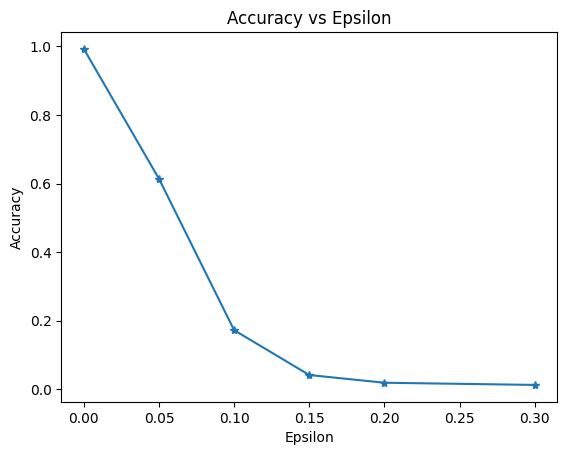

In [17]:
# 绘制扰动系数与模型准确率之间的关系图
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.show()

In [18]:
def to_numpy_array(tensor):
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

C:\Users\35083\AppData\Local\Temp\ipykernel_16564\1259978854.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


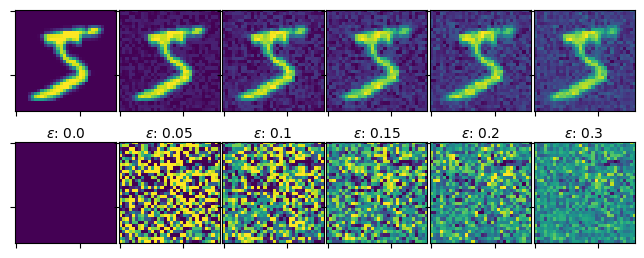

In [19]:
# 对比原始图像和攻击后的图像
for _, (imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    f = plt.figure(figsize=(8, 4))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.25) 

    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax1 = f.add_subplot(gs[0, i])
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = pgd_linf(model, imgs, labels, epsilon=eps, alpha=1e-2, num_iter=40)
        
        img, adv_img = imgs[0], adv_imgs[0]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    break